Notebook produces a regression for $\Delta$T/$\Delta${rsdscs} across multiple SAI scenarios simulated in UKESM1

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import logging
#import esmvalcore.preprocessor
import xarray as xr
from xmip.preprocessing import rename_cmip6
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cftime
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

var = 'rsdscs'

lat_band = 'Global'

In [2]:
lat_band_dict = {'Tropics':[-23, 23], 
                 'Arctic':[60, 91],
                 'Antarctic':[-91, -60],
                 'Global':[-91, 91]}

lat1, lat2 = lat_band_dict[lat_band][0], lat_band_dict[lat_band][1]

##### NB
#####
##### we only subset latitude for the temperature response, 
##### not the change in fluxes, 
##### which we always take to represent
##### a global mean forcing

In [3]:
# get ssp245 first:
def get_ssp245_ds(variable, table='Amon', grid='gn'):
    ds_list = []
    for es in ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
        path = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/{e}/{t}/{v}/{g}/latest/'.format(e=es, t=table,v=variable, g=grid)
        #files = os.listdir(path)
        ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
        ds_list.append(ds)
    
    DS = xr.concat(ds_list, dim='Ensemble_member')
    return DS

ds_ssp245 = get_ssp245_ds(var).rename({'y':'latitude'})

# also get ARISE data
table='Amon'
### get ensemble mean for both scenarios 
ds_list_pr = []
paths_pr = glob.glob('/badc/deposited2022/arise/data/ARISE/MOHC/UKESM1-0-LL/arise-sai-1p5/*/{t}/{v}/gn/*/'.format(t=table,v=var))

for path in paths_pr:
    #files = os.listdir(path)
    ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
    ds_list_pr.append(ds)

DS_ARISE = xr.concat(ds_list_pr, dim='Ensemble_member').rename({'y':'latitude'}) - ds_ssp245
DS_ARISE_annual = DS_ARISE.groupby(DS_ARISE.time.dt.year).mean()
weights = np.cos(np.deg2rad(DS_ARISE_annual['latitude']))
DS_ARISE_annual_w = DS_ARISE_annual.weighted(weights).mean(dim='latitude').mean('x')
DS_ARISE_annual_gm = DS_ARISE_annual_w[var]

### also get global mean tas under ARISE and SSP245:
tas_245 = get_ssp245_ds(variable='tas', table='Amon', grid='gn').load().mean(dim='x')
tas_245 = tas_245.groupby(tas_245.time.dt.year).mean().sel(y=slice(lat1, lat2))
tas_245 = tas_245.weighted(np.cos(np.deg2rad(tas_245['y']))).mean(dim='y')

ds_list_tas = []
paths_tas = glob.glob('/badc/deposited2022/arise/data/ARISE/MOHC/UKESM1-0-LL/arise-sai-1p5/*/Amon/tas/gn/*/')
for path in paths_tas:
    ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
    ds_list_tas.append(ds)
tas_arise = xr.concat(ds_list_tas, dim='Ensemble_member').load().mean(dim='x')
tas_arise = tas_arise.groupby(tas_arise.time.dt.year).mean().sel(y=slice(lat1, lat2))
tas_arise = tas_arise.weighted(np.cos(np.deg2rad(tas_arise['y']))).mean(dim='y')
tas_arise_anom = (tas_arise - tas_245).load()

In [4]:
"""
i=0
for es in ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    plt.scatter(DS_ARISE_annual_gm.sel(Ensemble_member=i).values, tas_arise_anom.sel(Ensemble_member=i).tas.values)
    i=i+1
plt.xlabel('Global mean {v} change'.format(v=var))
plt.ylabel('{} mean cooling under ARISE'.format(lat_band))
"""

"\ni=0\nfor es in ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:\n    plt.scatter(DS_ARISE_annual_gm.sel(Ensemble_member=i).values, tas_arise_anom.sel(Ensemble_member=i).tas.values)\n    i=i+1\nplt.xlabel('Global mean {v} change'.format(v=var))\nplt.ylabel('{} mean cooling under ARISE'.format(lat_band))\n"

In [5]:
### repeat for MH's 60 and eq 1.5 targeting sai

MH_run_archive = '/gws/nopw/j04/moghli/MH_runs/'

MH_inj_loc_dict = {'u-cs992':'30NS_1.5C',
                   'u-cs993':'30NS_1.5C',
                   'u-cs994':'30NS_1.5C',
                   'u-cs995':'30NS_1.5C',
                   'u-ct762':'60NS_1.5C',
                   'u-ct808':'60NS_1.5C',
                   'u-ct809':'60NS_1.5C'}

MH_30_runs = ['u-cs992', 'u-cs993', 'u-cs994', 'u-cs995']
MH_60_runs = ['u-ct762', 'u-cy808', 'u-cy809']


ds_list = []
for run in MH_30_runs:
    dir = MH_run_archive+run+'/'+var+'_M/'
    file = os.listdir(dir)[0]
    ds = xr.open_dataset(dir+file)
    delta_time = ds['time'][0].item() - ds_ssp245.sel(time='2034')['time'][0].item()
    ds['time'] = ds['time'] - delta_time
    ds_list.append(ds)
DS_MH_30 = xr.concat(ds_list, dim='Ensemble_member').rename({'y':'latitude'}) - ds_ssp245.isel(Ensemble_member=slice(0, len(MH_30_runs)))
DS_MH_30_annual = DS_MH_30.groupby(DS_MH_30.time.dt.year).mean()
weights = np.cos(np.deg2rad(DS_MH_30_annual['latitude']))
DS_MH_30_annual_w = DS_MH_30_annual.weighted(weights).mean(dim='latitude').mean('x')
DS_MH_30_annual_gm = DS_MH_30_annual_w[var]


ds_list = []
for run in MH_60_runs:
    dir = MH_run_archive+run+'/'+var+'_M/'
    file = os.listdir(dir)[0]
    ds = xr.open_dataset(dir+file)
    delta_time = ds['time'][0].item() - ds_ssp245.sel(time='2034')['time'][0].item()
    ds['time'] = ds['time'] - delta_time
    ds_list.append(ds)
DS_MH_60 = xr.concat(ds_list, dim='Ensemble_member').rename({'y':'latitude'}) - ds_ssp245.isel(Ensemble_member=slice(0, len(MH_60_runs)))
DS_MH_60_annual = DS_MH_60.groupby(DS_MH_60.time.dt.year).mean()
weights = np.cos(np.deg2rad(DS_MH_60_annual['latitude']))
DS_MH_60_annual_w = DS_MH_60_annual.weighted(weights).mean(dim='latitude').mean('x')
DS_MH_60_annual_gm = DS_MH_60_annual_w[var]


ds_list = []
for run in MH_30_runs:
    dir = MH_run_archive+run+'/'+'tas/'
    file = os.listdir(dir)[0]
    ds = xr.open_dataset(dir+file)
    ds_list.append(ds)
tas_MH_30 = xr.concat(ds_list, dim='Ensemble_member')
tas_MH_30 = tas_MH_30.mean(dim='longitude')
tas_MH_30 = tas_MH_30.groupby(tas_MH_30.time.dt.year).mean().sel(latitude=slice(lat1, lat2))
tas_MH_30 = tas_MH_30.weighted(np.cos(np.deg2rad(tas_MH_30['latitude']))).mean(dim='latitude')
tas_MH_30 = tas_MH_30.rename({'air_temperature':'tas'})
tas_MH_30 = tas_MH_30 - tas_245.isel(Ensemble_member=slice(0, len(MH_30_runs)))

ds_list = []
for run in MH_60_runs:
    dir = MH_run_archive+run+'/'+'tas/'
    file = os.listdir(dir)[0]
    ds = xr.open_dataset(dir+file)
    ds_list.append(ds)
tas_MH_60 = xr.concat(ds_list, dim='Ensemble_member')
tas_MH_60 = tas_MH_60.mean(dim='longitude')
tas_MH_60 = tas_MH_60.groupby(tas_MH_60.time.dt.year).mean().sel(latitude=slice(lat1, lat2))
tas_MH_60 = tas_MH_60.weighted(np.cos(np.deg2rad(tas_MH_60['latitude']))).mean(dim='latitude')
tas_MH_60 = tas_MH_60.rename({'air_temperature':'tas'})
tas_MH_60 = tas_MH_60 - tas_245.isel(Ensemble_member=slice(0, len(MH_60_runs)))



In [6]:
"""
## check the yearly relationships for the 30NS and 60NS runs:

fix, axs = plt.subplots(1, 2, figsize=(10, 6))

ax = axs[0]
i=0
for es in ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2']:
    ax.scatter(DS_MH_30_annual_gm.sel(Ensemble_member=i).values, tas_MH_30.sel(Ensemble_member=i).tas.values)
    i=i+1
    ax.set_xlabel('global mean {}'.format(var))
    ax.set_ylabel('{} mean cooling'.format(lat_band))
    ax.set_title('30NS_1.5C')

ax = axs[1]
i=0
for es in ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2']:
    ax.scatter(DS_MH_60_annual_gm.sel(Ensemble_member=i).values, tas_MH_60.sel(Ensemble_member=i).tas.values)
    i=i+1
    ax.set_xlabel('global mean {}'.format(var))
    ax.set_ylabel('{} mean cooling'.format(lat_band))
    ax.set_title('60NS_1.5C')
    
plt.tight_layout()
"""

"\n## check the yearly relationships for the 30NS and 60NS runs:\n\nfix, axs = plt.subplots(1, 2, figsize=(10, 6))\n\nax = axs[0]\ni=0\nfor es in ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2']:\n    ax.scatter(DS_MH_30_annual_gm.sel(Ensemble_member=i).values, tas_MH_30.sel(Ensemble_member=i).tas.values)\n    i=i+1\n    ax.set_xlabel('global mean {}'.format(var))\n    ax.set_ylabel('{} mean cooling'.format(lat_band))\n    ax.set_title('30NS_1.5C')\n\nax = axs[1]\ni=0\nfor es in ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2']:\n    ax.scatter(DS_MH_60_annual_gm.sel(Ensemble_member=i).values, tas_MH_60.sel(Ensemble_member=i).tas.values)\n    i=i+1\n    ax.set_xlabel('global mean {}'.format(var))\n    ax.set_ylabel('{} mean cooling'.format(lat_band))\n    ax.set_title('60NS_1.5C')\n    \nplt.tight_layout()\n"

In [7]:
### now repeat for G6 and ssp585:

def get_ssp585_ds(variable, table='Amon', grid='gn'):
    ds_list = []
    for es in ['r1i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
        path = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/{e}/{t}/{v}/{g}/latest/'.format(e=es, t=table,v=variable, g=grid)
        #files = os.listdir(path)
        ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
        ds_list.append(ds)
    
    DS = xr.concat(ds_list, dim='Ensemble_member')
    return DS

ds_ssp585 = get_ssp585_ds(var)
ds_ssp585 = ds_ssp585.rename({'y':'latitude'})

def get_g6_ds(scen, variable, table='Amon', grid='gn'):
    ds_list = []
    for es in ['r1i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
        path = '/badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/{s}/{e}/{t}/{v}/{g}/latest/'.format(s=scen, e=es, t=table,v=variable, g=grid)
        ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
        ds_list.append(ds)    
    DS = xr.concat(ds_list, dim='Ensemble_member')
    return DS
ds_g6sulfur = get_g6_ds('G6sulfur', var)
ds_g6solar = get_g6_ds('G6solar', var)

tas_585 = get_ssp585_ds(variable='tas', table='Amon', grid='gn').mean(dim='x').sel(y=slice(lat1, lat2))
tas_585 = tas_585.groupby(tas_585.time.dt.year).mean()
tas_585 = tas_585.weighted(np.cos(np.deg2rad(tas_585['y']))).mean(dim='y')

tas_g6sulfur = get_g6_ds('G6sulfur', variable='tas', table='Amon', grid='gn').mean(dim='x').sel(y=slice(lat1, lat2))
tas_g6sulfur = tas_g6sulfur.groupby(tas_g6sulfur.time.dt.year).mean()
tas_g6sulfur = tas_g6sulfur.weighted(np.cos(np.deg2rad(tas_g6sulfur['y']))).mean(dim='y')

tas_g6solar = get_g6_ds('G6sulfur', variable='tas', table='Amon', grid='gn').mean(dim='x').sel(y=slice(lat1, lat2))
tas_g6solar = tas_g6solar.groupby(tas_g6solar.time.dt.year).mean()
tas_g6solar = tas_g6solar.weighted(np.cos(np.deg2rad(tas_g6solar['y']))).mean(dim='y')


ds_g6sulfur = ds_g6sulfur.rename({'y':'latitude'}) - ds_ssp585
ds_g6solar = ds_g6solar.rename({'y':'latitude'}) - ds_ssp585

ds_g6sulfur = ds_g6sulfur.groupby(ds_g6sulfur.time.dt.year).mean()
ds_g6solar = ds_g6solar.groupby(ds_g6solar.time.dt.year).mean()

weights = np.cos(np.deg2rad(ds_g6sulfur['latitude']))
ds_g6sulfur_w =ds_g6sulfur.weighted(weights).mean(dim='latitude').mean('x')
ds_g6sulfur_annual_gm = ds_g6sulfur_w[var].load()

weights = np.cos(np.deg2rad(ds_g6solar['latitude']))
ds_g6solar_w =ds_g6solar.weighted(weights).mean(dim='latitude').mean('x')
ds_g6solar_annual_gm = ds_g6solar_w[var].load()

tas_anom_g6sulfur = (tas_g6sulfur - tas_585).load()
tas_anom_g6solar = (tas_g6solar - tas_585).load()

In [8]:
"""
i=0
for es in ['r1i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    plt.scatter(ds_g6sulfur_annual_gm.sel(Ensemble_member=i).values, tas_anom_g6sulfur.sel(Ensemble_member=i).tas.values)
    i=i+1
plt.xlabel('global mean {}'.format(var))
plt.ylabel('{} mean cooling under G6sulfur'.format(lat_band))
"""    

"\ni=0\nfor es in ['r1i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:\n    plt.scatter(ds_g6sulfur_annual_gm.sel(Ensemble_member=i).values, tas_anom_g6sulfur.sel(Ensemble_member=i).tas.values)\n    i=i+1\nplt.xlabel('global mean {}'.format(var))\nplt.ylabel('{} mean cooling under G6sulfur'.format(lat_band))\n"

rsdscs for -1°C from linear fit: -3.16 W/m2
rsdscs for -1°C (from cooling/SW for each point): 3.09 W/m2
+- 0.1


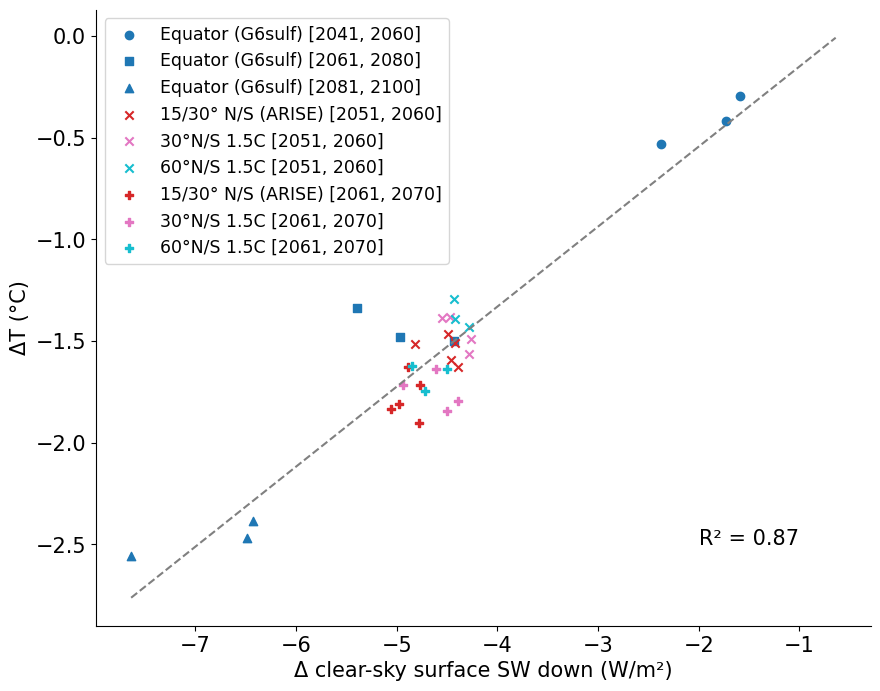

In [9]:
### MAIN PLOT: 

arise_years_early = [2051, 2060]
arise_years_late = [2061, 2070]
G6_years_0 = [2041, 2060]
G6_years_1 = [2061, 2080]
G6_years_2 = [2081, 2100]

#cols = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
cmap = sns.color_palette("tab10", as_cmap=True)
cols = cmap(np.linspace(0, 1, 4))

xs, ys = [], []
fig, ax = plt.subplots(figsize=(10, 8))


i=0
for es in ['r1i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = ds_g6sulfur_annual_gm.sel(Ensemble_member=i).sel(year=slice(G6_years_0[0], G6_years_0[1])).mean('year').values
    y = tas_anom_g6sulfur.sel(Ensemble_member=i).sel(year=slice(G6_years_0[0], G6_years_0[1])).mean('year').tas.values
    ax.scatter(x, y, c=cols[0], marker='o')
    if i==0:
        ax.scatter([], [], c=cols[0], marker='o', label=str('Equator (G6sulf) '+str(G6_years_0)))
    xs.append(x)
    ys.append(y)
    i=i+1

i=0
for es in ['r1i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = ds_g6sulfur_annual_gm.sel(Ensemble_member=i).sel(year=slice(G6_years_1[0], G6_years_1[1])).mean('year').values
    y = tas_anom_g6sulfur.sel(Ensemble_member=i).sel(year=slice(G6_years_1[0], G6_years_1[1])).mean('year').tas.values
    ax.scatter(x, y, c=cols[0], marker='s')
    if i==0:
        ax.scatter([], [], c=cols[0], marker='s', label=str('Equator (G6sulf) '+str(G6_years_1)))
    xs.append(x)
    ys.append(y)
    i=i+1
    
i=0
for es in ['r1i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = ds_g6sulfur_annual_gm.sel(Ensemble_member=i).sel(year=slice(G6_years_2[0], G6_years_2[1])).mean('year').values
    y = tas_anom_g6sulfur.sel(Ensemble_member=i).sel(year=slice(G6_years_2[0], G6_years_2[1])).mean('year').tas.values
    ax.scatter(x, y, c=cols[0], marker='^')
    if i==0:
        ax.scatter([], [], c=cols[0], marker='^', label=str('Equator (G6sulf) '+str(G6_years_2)))
    xs.append(x)
    ys.append(y)
    i=i+1

i=0
for es in ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = DS_ARISE_annual_gm.sel(Ensemble_member=i).sel(year=slice(arise_years_early[0], arise_years_early[1])).mean('year').values
    y = tas_arise_anom.sel(Ensemble_member=i).sel(year=slice(arise_years_early[0], arise_years_early[1])).mean('year').tas.values
    ax.scatter(x, y, c=cols[1], marker='x')
    if i==0:
        ax.scatter([], [], c=cols[1], marker='x', label=str('15/30° N/S (ARISE) '+str(arise_years_early)))
    xs.append(x)
    ys.append(y)
    i=i+1


    
i=0
for es in ['r1i1p1f2', 'r2i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = DS_MH_30_annual_gm.sel(Ensemble_member=i).sel(year=slice(arise_years_early[0], arise_years_early[1])).mean('year').values
    y = tas_MH_30.sel(Ensemble_member=i).sel(year=slice(arise_years_early[0], arise_years_early[1])).mean('year').tas.values
    ax.scatter(x, y, c=cols[2], marker='x')
    if i==0:
        ax.scatter([], [], c=cols[2], marker='x', label=str('30°N/S 1.5C '+str(arise_years_early)))
    xs.append(x)
    ys.append(y)
    i=i+1

i=0
for es in ['r1i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = DS_MH_60_annual_gm.sel(Ensemble_member=i).sel(year=slice(arise_years_early[0], arise_years_early[1])).mean('year').values
    y = tas_MH_60.sel(Ensemble_member=i).sel(year=slice(arise_years_early[0], arise_years_early[1])).mean('year').tas.values
    ax.scatter(x, y, c=cols[3], marker='x')
    if i==0:
        ax.scatter([], [], c=cols[3], marker='x', label=str('60°N/S 1.5C '+str(arise_years_early)))
    xs.append(x)
    ys.append(y)
    i=i+1


i=0
for es in ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = DS_ARISE_annual_gm.sel(Ensemble_member=i).sel(year=slice(arise_years_late[0], arise_years_late[1])).mean('year').values
    y = tas_arise_anom.sel(Ensemble_member=i).sel(year=slice(arise_years_late[0], arise_years_late[1])).mean('year').tas.values
    ax.scatter(x, y, c=cols[1], marker='P')
    if i==0:
        ax.scatter([], [], c=cols[1], marker='P', label=str('15/30° N/S (ARISE) '+str(arise_years_late)))
    xs.append(x)
    ys.append(y)
    i=i+1
    

i=0
for es in ['r1i1p1f2', 'r2i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = DS_MH_30_annual_gm.sel(Ensemble_member=i).sel(year=slice(arise_years_late[0], arise_years_late[1])).mean('year').values
    y = tas_MH_30.sel(Ensemble_member=i).sel(year=slice(arise_years_late[0], arise_years_late[1])).mean('year').tas.values
    ax.scatter(x, y, c=cols[2], marker='P')
    if i==0:
        ax.scatter([], [], c=cols[2], marker='P', label=str('30°N/S 1.5C '+str(arise_years_late)))
    xs.append(x)
    ys.append(y)
    i=i+1


i=0
for es in ['r1i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = DS_MH_60_annual_gm.sel(Ensemble_member=i).sel(year=slice(arise_years_late[0], arise_years_late[1])).mean('year').values
    y = tas_MH_60.sel(Ensemble_member=i).sel(year=slice(arise_years_late[0], arise_years_late[1])).mean('year').tas.values
    ax.scatter(x, y, c=cols[3], marker='P')
    if i==0:
        ax.scatter([], [], c=cols[3], marker='P', label=str('60°N/S 1.5C '+str(arise_years_late)))
    xs.append(x)
    ys.append(y)
    i=i+1

regression = stats.linregress(xs, ys)
slope, intercept = regression.slope, regression.intercept
x_points = np.arange(np.min(xs), np.max(xs)+1, 0.1)
y_vals = intercept + slope*x_points
ax.plot(x_points, y_vals, c='gray', ls='--')


print('{} for -1°C from linear fit: '.format(var)+str(np.round((-1-intercept)/slope, 2))+' W/m2')

## recalc as simple (cooling)/(rsdscs) for each point: 
rs = []
for i in range(len(xs)):
    r = xs[i]/ys[i]
    rs.append(r)
print('{} for -1°C (from cooling/SW for each point): '.format(var)+str(np.round(np.mean(rs), 2))+' W/m2')
print('+- '+str(np.round(stats.sem(rs), 1)))

ax.text(s=str('R\u00b2 = '+str(np.round(regression.rvalue**2, 2))), x=-2, y=-2.5)
ax.set_xlabel('Δ clear-sky surface SW down (W/m\u00b2)')
ax.set_ylabel('ΔT (°C)')
ax.legend(fontsize='small')
ax.spines[['right', 'top']].set_visible(False)

plt.savefig('Figures/Supp/{v}_versus_{l}_cooling_V2.jpg'.format(v=var, l=lat_band), dpi=300, bbox_inches='tight')

#### now also check the global to tropical cooling ratio

In [10]:
### also add a plot of tropical cooling per degree global cooling
tas_245 = get_ssp245_ds(variable='tas', table='Amon', grid='gn').load().mean(dim='x')
tas_245_tropics = tas_245.groupby(tas_245.time.dt.year).mean().sel(y=slice(lat_band_dict['Tropics'][0], lat_band_dict['Tropics'][1]))
tas_245_tropics = tas_245_tropics.weighted(np.cos(np.deg2rad(tas_245_tropics['y']))).mean(dim='y')
tas_245 = tas_245.groupby(tas_245.time.dt.year).mean()
tas_245 = tas_245.weighted(np.cos(np.deg2rad(tas_245['y']))).mean(dim='y')

tas_585 = get_ssp585_ds(variable='tas', table='Amon', grid='gn').mean(dim='x')
tas_585_tropics = tas_585.groupby(tas_585.time.dt.year).mean().sel(y=slice(lat_band_dict['Tropics'][0], lat_band_dict['Tropics'][1]))
tas_585_tropics = tas_585_tropics.weighted(np.cos(np.deg2rad(tas_585_tropics['y']))).mean(dim='y')
tas_585 = tas_585.groupby(tas_585.time.dt.year).mean()
tas_585 = tas_585.weighted(np.cos(np.deg2rad(tas_585['y']))).mean(dim='y')

tas_g6sulfur = get_g6_ds('G6sulfur', variable='tas', table='Amon', grid='gn').mean(dim='x')
tas_g6sulfur_tropics = tas_g6sulfur.groupby(tas_g6sulfur.time.dt.year).mean().sel(y=slice(lat_band_dict['Tropics'][0], lat_band_dict['Tropics'][1]))
tas_g6sulfur_tropics = tas_g6sulfur_tropics.weighted(np.cos(np.deg2rad(tas_g6sulfur_tropics['y']))).mean(dim='y')
tas_g6sulfur = tas_g6sulfur.groupby(tas_g6sulfur.time.dt.year).mean()
tas_g6sulfur = tas_g6sulfur.weighted(np.cos(np.deg2rad(tas_g6sulfur['y']))).mean(dim='y')

tas_anom_g6sulfur = (tas_g6sulfur - tas_585).load()
tas_anom_g6sulfur_tropics = (tas_g6sulfur_tropics - tas_585_tropics).load()

ds_list = []
for run in MH_30_runs:
    dir = MH_run_archive+run+'/'+'tas/'
    file = os.listdir(dir)[0]
    ds = xr.open_dataset(dir+file)
    ds_list.append(ds)
tas_MH_30 = xr.concat(ds_list, dim='Ensemble_member')
tas_MH_30 = tas_MH_30.mean(dim='longitude')

tas_MH_30_tropics = tas_MH_30.groupby(tas_MH_30.time.dt.year).mean().sel(latitude=slice(lat_band_dict['Tropics'][0], lat_band_dict['Tropics'][1]))
tas_MH_30_tropics = tas_MH_30_tropics.weighted(np.cos(np.deg2rad(tas_MH_30_tropics['latitude']))).mean(dim='latitude')
tas_MH_30_tropics = tas_MH_30_tropics.rename({'air_temperature':'tas'})
tas_MH_30_tropics = tas_MH_30_tropics - tas_245_tropics.isel(Ensemble_member=slice(0, len(MH_30_runs)))
tas_MH_30 = tas_MH_30.groupby(tas_MH_30.time.dt.year).mean().sel(latitude=slice(lat1, lat2))
tas_MH_30 = tas_MH_30.weighted(np.cos(np.deg2rad(tas_MH_30['latitude']))).mean(dim='latitude')
tas_MH_30 = tas_MH_30.rename({'air_temperature':'tas'})
tas_MH_30 = tas_MH_30 - tas_245.isel(Ensemble_member=slice(0, len(MH_30_runs)))

ds_list = []
for run in MH_60_runs:
    dir = MH_run_archive+run+'/'+'tas/'
    file = os.listdir(dir)[0]
    ds = xr.open_dataset(dir+file)
    ds_list.append(ds)
tas_MH_60 = xr.concat(ds_list, dim='Ensemble_member')
tas_MH_60 = tas_MH_60.mean(dim='longitude')

tas_MH_60_tropics = tas_MH_60.groupby(tas_MH_60.time.dt.year).mean().sel(latitude=slice(lat_band_dict['Tropics'][0], lat_band_dict['Tropics'][1]))
tas_MH_60_tropics = tas_MH_60_tropics.weighted(np.cos(np.deg2rad(tas_MH_60_tropics['latitude']))).mean(dim='latitude')
tas_MH_60_tropics = tas_MH_60_tropics.rename({'air_temperature':'tas'})
tas_MH_60_tropics = tas_MH_60_tropics - tas_245_tropics.isel(Ensemble_member=slice(0, len(MH_60_runs)))
tas_MH_60 = tas_MH_60.groupby(tas_MH_60.time.dt.year).mean().sel(latitude=slice(lat1, lat2))
tas_MH_60 = tas_MH_60.weighted(np.cos(np.deg2rad(tas_MH_60['latitude']))).mean(dim='latitude')
tas_MH_60 = tas_MH_60.rename({'air_temperature':'tas'})
tas_MH_60 = tas_MH_60 - tas_245.isel(Ensemble_member=slice(0, len(MH_60_runs)))

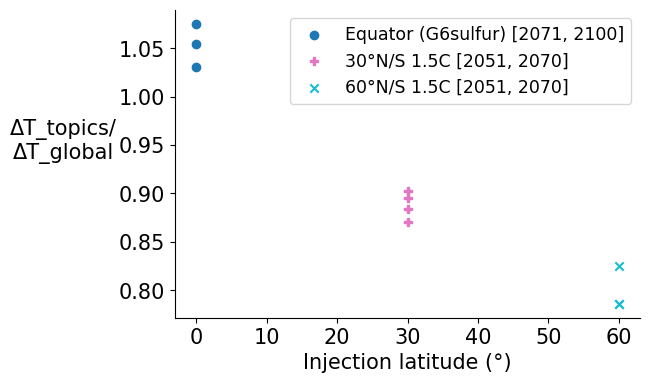

In [11]:
arise_years = [2051, 2070]
G6_years = [2071, 2100]

#cols = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
cmap = sns.color_palette("tab10", as_cmap=True)
cols = cmap(np.linspace(0, 1, 4))

xs, ys = [], []
fig, ax = plt.subplots(figsize=(6, 4))

i=0
for es in ['r1i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = 0
    y = tas_anom_g6sulfur_tropics.sel(Ensemble_member=i).sel(year=slice(G6_years[0], G6_years[1])).mean('year').tas.values.item()/tas_anom_g6sulfur.sel(Ensemble_member=i).sel(year=slice(G6_years[0], G6_years[1])).mean('year').tas.values.item()
    ax.scatter(x, y, c=cols[0], marker='o')
    if i==0:
        ax.scatter([], [], c=cols[0], marker='o', label=str('Equator (G6sulfur) '+str(G6_years)))
    xs.append(x)
    ys.append(y)
    i=i+1

i=0
for es in ['r1i1p1f2', 'r2i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = 30
    y = tas_MH_30_tropics.sel(Ensemble_member=i).sel(year=slice(arise_years[0], arise_years[1])).mean('year').tas.values.item()/tas_MH_30.sel(Ensemble_member=i).sel(year=slice(arise_years[0], arise_years[1])).mean('year').tas.values.item()
    ax.scatter(x, y, c=cols[2], marker='P')
    if i==0:
        ax.scatter([], [], c=cols[2], marker='P', label=str('30°N/S 1.5C '+str(arise_years)))
    xs.append(x)
    ys.append(y)
    i=i+1

i=0
for es in ['r1i1p1f2', 'r4i1p1f2', 'r8i1p1f2']:
    x = 60
    y = tas_MH_60_tropics.sel(Ensemble_member=i).sel(year=slice(arise_years[0], arise_years[1])).mean('year').tas.values.item()/tas_MH_60.sel(Ensemble_member=i).sel(year=slice(arise_years[0], arise_years[1])).mean('year').tas.values.item()
    ax.scatter(x, y, c=cols[3], marker='x')
    if i==0:
        ax.scatter([], [], c=cols[3], marker='x', label=str('60°N/S 1.5C '+str(arise_years)))
    xs.append(x)
    ys.append(y)
    i=i+1

ax.set_xlabel('Injection latitude (°)')
ax.set_ylabel('ΔT_topics/\nΔT_global', rotation =0, labelpad=40)
ax.legend(fontsize='small')

ax.spines[['right', 'top']].set_visible(False)
plt.savefig('Figures/Supp/Tropical_cooling_per_unit_global.jpg', dpi=300, bbox_inches='tight')